# Predykcja cen akcji na podstawie historii

In [35]:
import pandas as pd

# StockDataFile.csv to plik CSV pobrany na przykład ze strony internetowej giełdy, na której
# notowana jest spółka akcyjna, której te dane dotyczą. W przykładzie podanym poniżej dane dotyczyły
# spółki notowanej na giełdzie NASDAQ.
df = pd.read_csv('StockDataFile.csv')
df.head(5)

### Konwersja kolumny "Date" do formatu DateTime

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.head(10)

,Date,Close/Last,Volume,Open,High,Low
157,2024-01-02,$370.87,25258630,$373.86,$375.90,$366.771
156,2024-01-03,$370.60,23083470,$369.01,$373.2562,$368.51
155,2024-01-04,$367.94,20901500,$370.665,$373.10,$367.17
154,2024-01-05,$367.75,21004580,$368.97,$372.06,$366.50
153,2024-01-08,$374.69,23133970,$369.30,$375.20,$369.01
152,2024-01-09,$375.79,20829950,$372.01,$375.99,$371.19
151,2024-01-10,$382.77,25514250,$376.37,$384.17,$376.32
150,2024-01-11,$384.63,27850850,$386.00,$390.68,$380.38
149,2024-01-12,$388.47,21661150,$385.49,$388.68,$384.65
148,2024-01-16,$390.27,27202270,$393.66,$394.03,$387.6229


### Konwersja tekstu cen do wartości numerycznych

In [37]:
df['Close/Last'] = df['Close/Last'].str.replace('$', '')
df['Close/Last'] = pd.to_numeric(df['Close/Last'])

df['Open'] = df['Open'].str.replace('$', '')
df['Open'] = pd.to_numeric(df['Open'])

df['High'] = df['High'].str.replace('$', '')
df['High'] = pd.to_numeric(df['High'])

df['Low'] = df['Low'].str.replace('$', '')
df['Low'] = pd.to_numeric(df['Low'])

df.head(5)

,Date,Close/Last,Volume,Open,High,Low
157,2024-01-02,370.87,25258630,373.860,375.9000,366.771
156,2024-01-03,370.60,23083470,369.010,373.2562,368.510
155,2024-01-04,367.94,20901500,370.665,373.1000,367.170
154,2024-01-05,367.75,21004580,368.970,372.0600,366.500
153,2024-01-08,374.69,23133970,369.300,375.2000,369.010


### Podstawowe informacje o zbiorze danych

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, 157 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        158 non-null    datetime64[ns]
 1   Close/Last  158 non-null    float64       
 2   Volume      158 non-null    int64         
 3   Open        158 non-null    float64       
 4   High        158 non-null    float64       
 5   Low         158 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 8.6 KB


### Przedstawienie zmienności cen zamknięcia w czasie

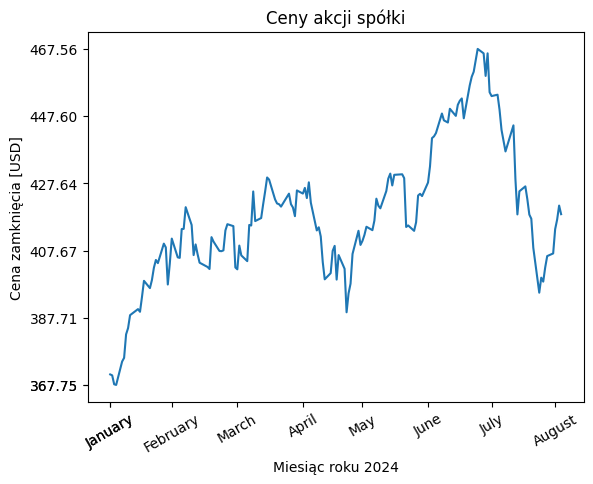

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

axes = sns.lineplot(data=df, x='Date', y='Close/Last')

x_ticks = [df['Date'].iloc[0]]
x_ticks += list(df['Date'].iloc[::len(df)//7])

x_ticks_labels = [df['Date'].dt.month_name().iloc[0]]
x_ticks_labels += list(df['Date'].dt.month_name().iloc[::len(df)//7])

y_min = df['Close/Last'].min()
y_max = df['Close/Last'].max()
# Minimalny punkt
y_ticks = [y_min]
# Kilka punktów pomiędzy wartością minimalną, a maksymalną
y_ticks += list([y_min + i * (y_max-y_min)/5 for i in range(5)])  
# Maksymalny punkt
y_ticks.append(y_max) 

# Ustawienie rozdziałki opisów osi X i Y
axes.set_xticks(ticks=x_ticks)
axes.set_xticklabels(labels=x_ticks_labels, rotation=30)
axes.set_yticks(y_ticks)
# Opis wykresu
plt.xlabel('Miesiąc roku 2024')
plt.ylabel('Cena zamknięcia [USD]')
plt.title('Ceny akcji spółki')
plt.show()


### Wykres zmienności cen akcji jako interpolacja

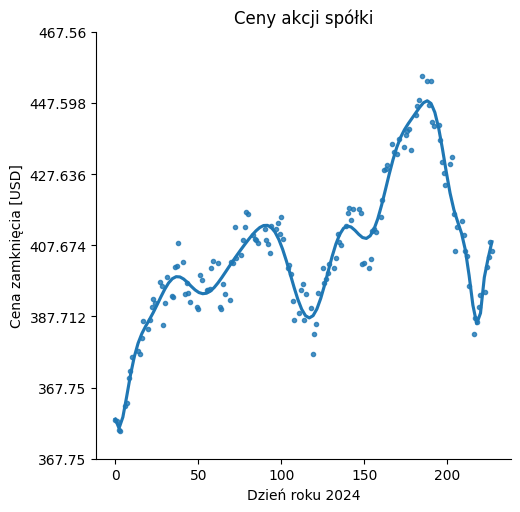

In [55]:
df['DateNumeric'] = (df['Date'] - df['Date'].min()).dt.days
axes = sns.lmplot(data=df, x='DateNumeric', y='Close/Last', order=32, ci=None, markers=".")

y_min = df['Close/Last'].min()
y_max = df['Close/Last'].max()
y_ticks = [y_min]  # Minimalny punkt
y_ticks += list([y_min + i * (y_max-y_min)/5 for i in range(5)])  # Kilka punktów pomiędzy
y_ticks.append(y_max)  # Maksymalny punkt

axes.set_yticklabels(labels=y_ticks)
# Opis wykresu
plt.xlabel('Dzień roku 2024')
plt.ylabel('Cena zamknięcia [USD]')
plt.title('Ceny akcji spółki')
plt.show()

### Dystrybucja cen zamknięcia USD

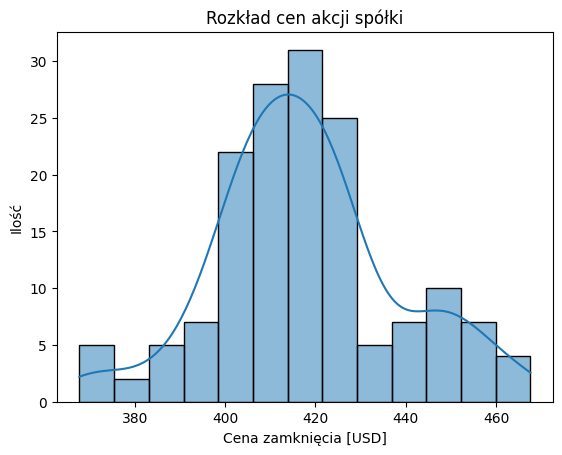

In [54]:
sns.histplot(data=df['Close/Last'],  kde=True).set_xlabel(xlabel='Cena zamkniecia [USD]')

# Opis wykresu
plt.xlabel('Cena zamknięcia [USD]')
plt.ylabel('Ilość')
plt.title('Rozkład cen akcji spółki')
plt.show()

### Przygotowanie danych

#### Podział na dane wejściowe do sieci i wyjściowe (które sieć ma przewidywać)

In [42]:
n_past = 30     # Ile ostatnich próbek bierzemy pod uwagę
n_out = 1   # Ile wartości ma przewidzieć kolejno nasza sieć

ceny_zamkniecia = df['Close/Last'].values

X = []
y = []

for i in range(n_past, len(ceny_zamkniecia) - n_out + 1):
    X.append(ceny_zamkniecia[i - n_past:i])  # Sekwencja z n_past dni
    y.append(ceny_zamkniecia[i:i + n_out])   # Cena akcji z dnia następnego dla danej sekwencji

#### Konwersja X i y na tablicę numpy

In [43]:
import numpy as np

X = np.array(X)
y = np.array(y)

#### Dzielimy dane na testowe i walidacyjne

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Standaryzacja i przygotowanie danych

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = [scaler.fit_transform(X_train_series.reshape(-1,1)) for X_train_series in X_train]
X_test_scaled = [scaler.fit_transform(X_test_series.reshape(-1,1)) for X_test_series in X_test]
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)

### Wizualizacja standaryzacji danych metodą MinMax

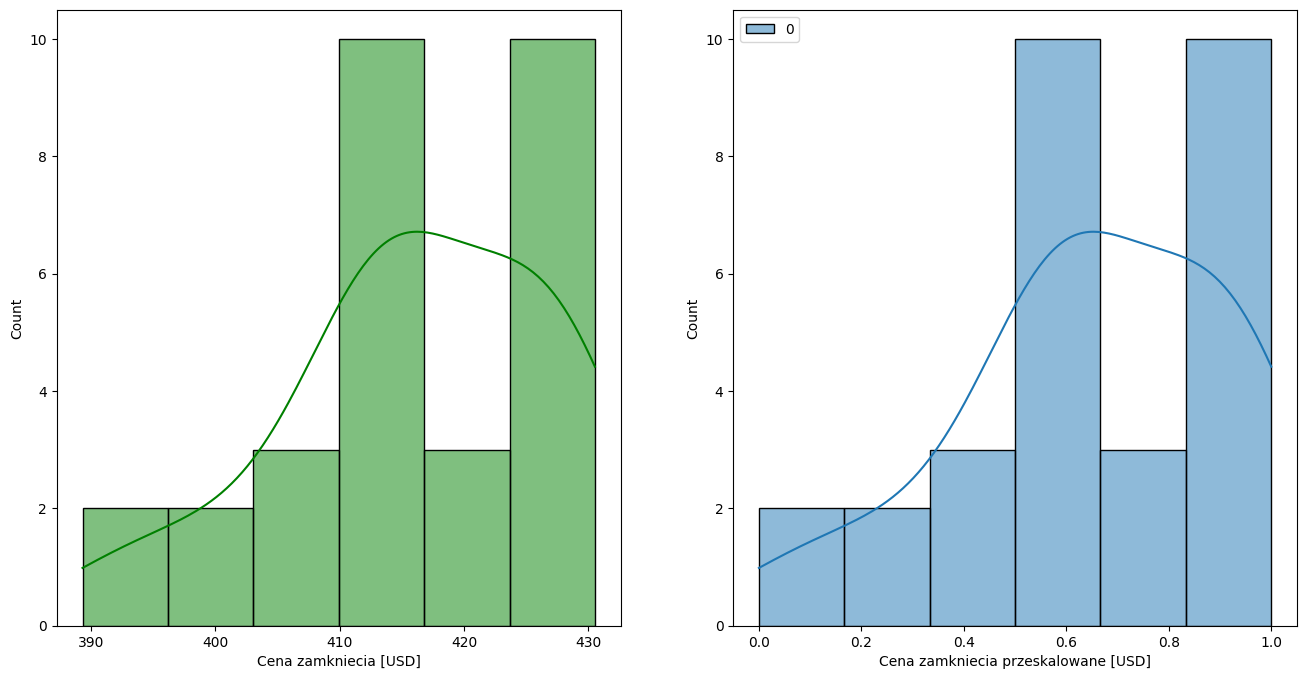

In [46]:
import matplotlib.pyplot as plt
first_training_row = X_train[0]
first_training_row_scaled = X_train_scaled[0]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
sns.histplot(data=first_training_row, color='green', kde=True, ax=ax1).set_xlabel(xlabel='Cena zamkniecia [USD]')
sns.histplot(data=first_training_row_scaled, kde=True, ax=ax2).set_xlabel(xlabel='Cena zamkniecia przeskalowane [USD]')
plt.show()

#### Konwersja danych na tensory

In [66]:
import torch

X_train_scaled = torch.tensor(np.array(X_train_scaled), dtype=torch.float32)
X_test_scaled = torch.tensor(np.array(X_test_scaled), dtype=torch.float32)
y_train_scaled = torch.tensor(np.array(y_train_scaled), dtype=torch.float32)
y_test_scaled = torch.tensor(np.array(y_test_scaled), dtype=torch.float32)

### Architektura / model sieci RNN oraz hiperparametry

In [48]:
from torch import nn

class StockPriceRNN(nn.Module):
    def __init__(self, input_data_features, hidden_size, num_layers, output_data_features):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_data_features, hidden_size=hidden_size, num_layers=num_layers,batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_data_features)

    def forward(self, x: torch.Tensor):
        # Format danych: [ilosc_wartw, ilosc_sekwencji, rozmiar_warstwy_ukrytej]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Pobieramy dane z sieci LSTM
        lstm_output, _ = self.lstm(x, (h0,c0))
        # Pobieramy ostatni stan ukryty
        last_lstm_hidden_state = lstm_output[:, -1, :]
        # Podajemy ostatni ukryty stan jako wyjście warstwy LSTM do warstwy liniowej
        output = self.fc(last_lstm_hidden_state)
        return output

### Inicjalizacja modelu

In [111]:
# Hiperparametry modelu
input_data_features = 1
hidden_size = 32
num_layers = 2
output_data_features = 1
learning_rate = 0.002

# Inicjalizacja modelu
model = StockPriceRNN(input_data_features=input_data_features, hidden_size=hidden_size, num_layers=num_layers, output_data_features=output_data_features)

# funkcja błędu oraz optymalizator
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Trening modelu

In [118]:
num_epochs = 1000
epochs = []
training_errors = []
for epoch in range(num_epochs):
    # Przełączamy model w tryb treningowy
    model.train()
    # Pobieramy predykcję dokonaną przez model
    outputs = model(X_train_scaled)
    # Zerujemy gradient optymalizatora
    optimizer.zero_grad()
    # Obliczanie błędu modelu
    loss = criterion(outputs, y_train_scaled)
    # Liczymy gradient dla obecnego błędu dla optymalizatora
    loss.backward()
    # Aktualizacja wag
    optimizer.step()

    # Zapisujemy numer iteracji (epokę) oraz błąd
    epochs.append(epoch + 1)
    training_errors.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Iteracja: {epoch+1}/{num_epochs}, błąd średnio-kwadratowy MSE: {loss:.5f}')

Iteracja: 10/1000, błąd średnio-kwadratowy MSE: 0.00001
Iteracja: 20/1000, błąd średnio-kwadratowy MSE: 0.00004
Iteracja: 30/1000, błąd średnio-kwadratowy MSE: 0.00003
Iteracja: 40/1000, błąd średnio-kwadratowy MSE: 0.00002
Iteracja: 50/1000, błąd średnio-kwadratowy MSE: 0.00001
Iteracja: 60/1000, błąd średnio-kwadratowy MSE: 0.00001
Iteracja: 70/1000, błąd średnio-kwadratowy MSE: 0.00010
Iteracja: 80/1000, błąd średnio-kwadratowy MSE: 0.00034
Iteracja: 90/1000, błąd średnio-kwadratowy MSE: 0.04509
Iteracja: 100/1000, błąd średnio-kwadratowy MSE: 0.03062
Iteracja: 110/1000, błąd średnio-kwadratowy MSE: 0.02697
Iteracja: 120/1000, błąd średnio-kwadratowy MSE: 0.02545
Iteracja: 130/1000, błąd średnio-kwadratowy MSE: 0.02441
Iteracja: 140/1000, błąd średnio-kwadratowy MSE: 0.02350
Iteracja: 150/1000, błąd średnio-kwadratowy MSE: 0.02235
Iteracja: 160/1000, błąd średnio-kwadratowy MSE: 0.02042
Iteracja: 170/1000, błąd średnio-kwadratowy MSE: 0.02541
Iteracja: 180/1000, błąd średnio-kwadrat

### Wizualizacja zmienności błędu podczas treningu modelu

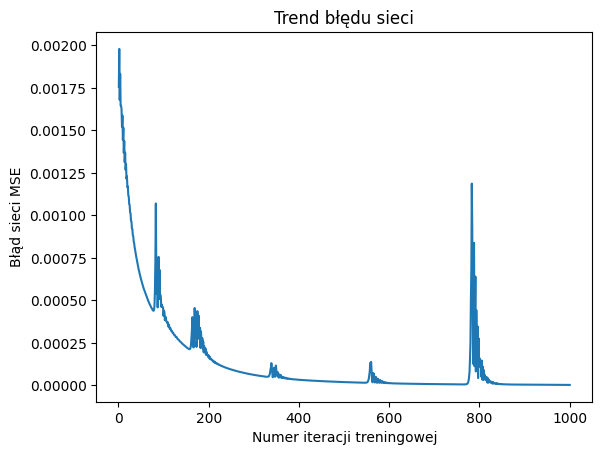

In [71]:
# Konwersja zebranych danych na obiekt DataFrame
training_data_df = pd.DataFrame()
training_data_df['Epochs'] = epochs
training_data_df['Errors'] = training_errors
# Wykres
sns.lineplot(data=training_data_df, x='Epochs', y='Errors')
# Opis wykresu
plt.xlabel('Numer iteracji treningowej')
plt.ylabel('Błąd sieci MSE')
plt.title('Trend błędu sieci')
plt.show()

### Walidacja modelu

In [119]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_scaled)
    test_loss_mse = criterion(test_outputs, y_test_scaled)
    print(f'Błąd średnio-kwadratowy: {test_loss_mse.item():.3f}')

Błąd średnio-kwadratowy: 0.055


### Przykład użycia

In [128]:
with torch.no_grad():
    index = -9
    test_day_data = X_test_scaled[index].unsqueeze(0)
    predicted_price = model(test_day_data)
    print(f"Przewidywana cena: {scaler.inverse_transform(predicted_price.numpy()).item():.2f}$, cena aktualna: {scaler.inverse_transform(y_test_scaled[index].unsqueeze(0)).item():.2f}$")

Przewidywana cena: 413.14$, cena aktualna: 412.32$
